###  Part 2. Correlation signals:

   __status of the vaccine recipients__:
     (ageGroup, gender, medical history, current illnes, current medication, allergy)
     
     __with__:

   > - __Recovery outcomes:__ (yes, no) after Vaccine administration
   > - __Serious outcomes__ after the administration each vaccine: (yes, no)
        (Death, life threatening, disability, emergency visit, prolonged hospitalized days)

In [1]:
# Handle table-like data and matrices
import numpy as np, pandas as pd, plotly.express as px, plotly.graph_objects as go, matplotlib.pyplot as plt, seaborn as sns
from plotly.subplots import make_subplots

import textwrap
from textwrap import wrap

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

import os
working_directory = os.getcwd()

In [2]:
# import the covid df
df_covid = pd.read_csv(working_directory+'/VAERSData/df_covid.csv')
df_covid.shape

(453559, 29)

In [3]:
# drop the columns we no longer will use in our next analysis
df_covid = df_covid.drop(['STATE','AGE_YRS', 'DATEDIED','HOSPDAYS', 'VAX_DATE','BIRTH_DEFECT', 'VAX_LOT', 'VAX_DOSE_SERIES', 'NUMDAYS'], axis=1).drop_duplicates(subset ='VAERS_ID')
df_covid.shape

(436116, 20)

In [4]:
df_Moderna = df_covid.loc[(df_covid.VAX_MANU.isin(['MODERNA']))]
df_Janssen = df_covid.loc[(df_covid.VAX_MANU.isin(['JANSSEN']))]
df_Pfizer = df_covid.loc[(df_covid.VAX_MANU.isin(['PFIZER\BIONTECH']))]

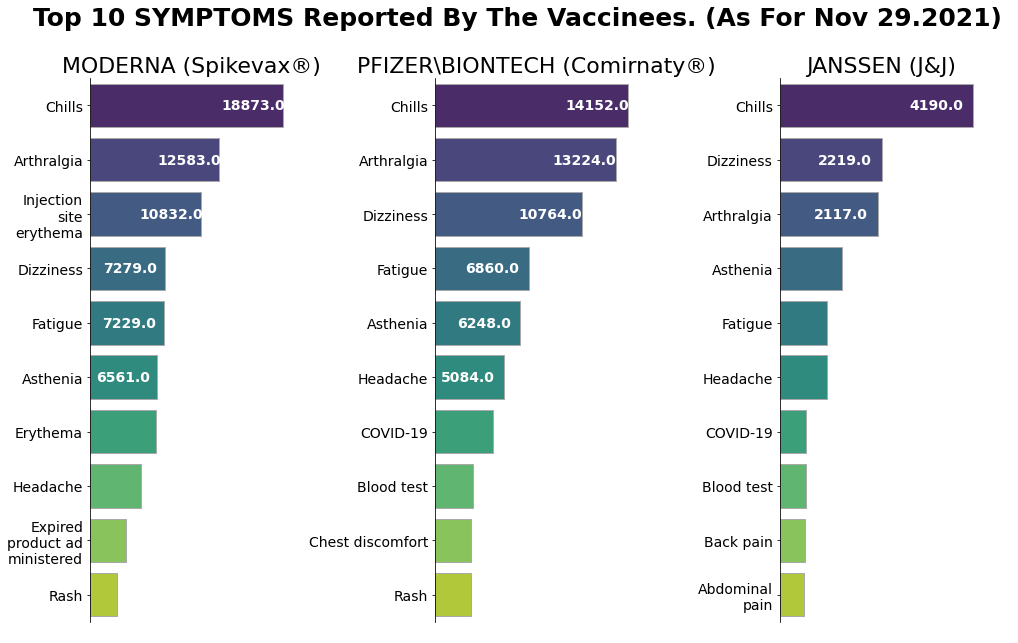

In [6]:
# Top 10 symptoms of SYMPTOM1 for Moderna, Pfizer, Janssen

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,10))

#fig = make_subplots(rows=1, cols=3)

modSymp1 = df_Moderna.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=modSymp1.index, x=modSymp1.values, ax=ax[0], palette='viridis', edgecolor='darkgray')
ax[0].set_yticklabels([textwrap.fill(e, 10) for e in modSymp1.index])
for p in ax[0].patches:
    width = p.get_width()
    ax[0].annotate(p.get_width(), xy=(p.get_width()-6500, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=14, weight='bold', color='white')
ax[0].set_title('MODERNA (Spikevax®)', fontsize=22)

pfSymp1 = df_Pfizer.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=pfSymp1.index, x=pfSymp1.values, ax=ax[1], palette='viridis', edgecolor='darkgray')
for p in ax[1].patches:
    width = p.get_width()
    ax[1].annotate(p.get_width(), xy=(p.get_width()-5000, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=14, weight='bold', color='white')
ax[1].set_title('PFIZER\BIONTECH (Comirnaty®)', fontsize=22)

JnsSymp1 = df_Janssen.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=JnsSymp1.index, x=JnsSymp1.values, ax=ax[2], palette='viridis', edgecolor='darkgray')
ax[2].set_yticklabels([textwrap.fill(e, 10) for e in JnsSymp1.index])
for p in ax[2].patches:
    width = p.get_width()
    ax[2].annotate(p.get_width(), xy=(p.get_width()-1500, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=14, weight='bold', color='white')
ax[2].set_title('JANSSEN (J&J)', fontsize=22)

for i in range(3):
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].tick_params(axis='x', bottom=False, labelbottom=False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xlabel(" ")

plt.suptitle('Top 10 SYMPTOMS Reported By The Vaccinees. (As For Nov 29.2021) ', fontsize=25, fontweight='bold')
plt.subplots_adjust(wspace=0.7) 
plt.show()

##### Very common side effects: may affect more than 1 in 10 people
• injection site: pain, swelling • tiredness • headache • muscle pain • chills • joint pain • diarrhoea • fever Lymphadenopathy, Pyrexia

*Some of these side effects were slightly more frequent in adolescents 12 to 15 years than in adults.

##### Common side effects: may affect up to 1 in 10 people
• injection site redness • nausea • vomiting Diarrhoea 

##### Uncommon side effects: may affect up to 1 in 100 people
• enlarged lymph nodes (more frequently observed after the booster dose) • feeling unwell • arm pain • insomnia • injection site itching • allergic reactions such as rash or itching • feeling weak or lack of energy/sleepy • decreased appetite • excessive sweating • night sweats

In [5]:
df_covid = df_covid.drop(['SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5','SYMPTOM1'], axis=1)

If we dropped the na values, we will lose more than 50% of the data which can negatively impact the interpretation

In [6]:
df_covid.CUR_ILL = df_covid.CUR_ILL.str.lower()

In [7]:
# filling NaN with "Not Specified" wich is the real interpretation
df_covid[['CUR_ILL', 'OTHER_MEDS', 'HISTORY', 'ALLERGIES']] =  df_covid[['CUR_ILL', 'OTHER_MEDS', 'HISTORY', 'ALLERGIES']].fillna('Not Specified', inplace=False)

# Filling NaN in Age column with the mean value
df_covid.ageGroup = df_covid.ageGroup.fillna('Adults:45-64',inplace=False)

In [8]:
# replacing all the inconsistent forms of "None" with "Clear" wich is the real interpretation
df_covid [['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']] =  df_covid [['OTHER_MEDS', 'CUR_ILL', 
                                                                     'HISTORY', 'ALLERGIES']].replace(['None',
'None.', 'Comments: Unknown', 'Unknown',"None Know Drug Allergies", "No known allergies.",
'No known allergies',"Nope", "Nope.", "nope","nop", "NO KNOWN ALLERGIES",
"no known allergies", "No Known Allergies", "no known allergies to foods or medications",
"noq", "noon", "Noon","noone","----", "---", "--", "-", "Not known drug allergy",
"not known", "Not know allergy", "No.", "no.", "Unknown.", "not", "None/ NKDA", "NOne","noneB",
"no-one", "nonw","Patient stated none", "Per patient none.","pt confirmed none", 
"pt disclosed none",  "No known serious allegies.", "NONE TO MY KNOWLEDGE",
"NO KNOWN", "No known allergis", "No know allergies","None/Unknown","Nonw",
"patient reports none","Patient stated none","per patient , none", "Pt reports none", 
"No Known Drug Allegies", "No known allergies to anything", "not reported (unknown)",
"nil known", "NOT APPLICABLE","Nonr", "nonr", "NONO","reports none",
"reports none taken at the time of vaccination",'None known',
'Comments: the patient had no known allergies and no known drug abuse or illicit drug usage', 
"No/ NA","NoNo", "Nonoe","Reportedly none", "PT states none","there are none noted",
"unknow; none reported", 'UNKNOWN', 'Na', 'N/a', 'na', 'none known', 'none reported',
'NO', "NON","None given", "None Report", "none known of",
"Non-known", "states none","STATES NONE", "States none.", "States none", 
"unknow none reported", "NONE LISTED ON VAR CONSENT SHEET", "Did not list any on VAR",
'None reported', 'NONE', 'no', 'No', "kno",'none', "N/A - NONE",
"No known", "no known",'NKDA','NKA', 'Unknown', "none so far", "none to date", "Don't know",
"Noe known", "Non-disclosed", "None stated/Denied","Nome","Nonr", 'unknown',"Unknown,",
'Not on any meds at home', "none on record", "Nonexistent", 
'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: None',
"non", "none.","None!", "None!!","Using none","Unknown, none reported",
"UNKNOWN, NONE REPORTED", '0', 'nka',"Nka", 
'Medical History/Concurrent Conditions: No adverse event (No reported medical history)',
"none per patient", 
"None per patient", "Unknown:  Believe none", "UNKNOWN; NONE NOTED", "UNKNOWN-NONE REPORTED",
'Medical History/Concurrent Conditions: No adverse event (No medical history reported)','NaN ',
'NaN', "NKA / none reported",
"Unknown seasonal / products", "not reported","None Reported", "NO medications",
"pt put none on form", "none known per patient", "nONE",'"None"', "(None)", 
"No Known Drug Allergies or history of adverse effects to vaccines per patient",
"nonenone", "none claimed","Nonenone",
"NoneNone", "noneNone","NoneNo", "Noneno", "nonee", "none/unknown", "None/unknown",
"none. NKDA","None. NKDA", 
'Not reported by patient', "NONE REPORTED.","NONE REPORTED", "None reported.",
"none reporred", "None Reported.", "None known.",
"none known.", "nothing known per patient", "nono", "No allergies","none provided",
"NONE PROVIDED.", "None per patient report",
"NO ALLERGIES", "Patient stated no known allergies", "NO ALLERGIES DOCUMENTED",
"none per pt", "NO Allergies",
"Patient reports no illnesses prior to or after Covid-19 vaccines.", "None on file",
"No according to patient's answers",
"Unknown - none at time of first injection.", "Healthy at vaccination.", 
"No known drug allergies", "No known drug allergies." ,
"No know drug allergies", "No food or drug allergies", "no known food or drug allergies",
"NO KNOWN DRUG ALLERGIES", "No Known Drug Allergy", "No known drug allergy", 
"none disclosed", "None documented in our system.", "None documented",
"None Documented","None that are known", "none that are known","None that are aware of.",
"none specified","None specified",
"none listed", "None listed", "NONE REPORTED", "none - ever", "None that i know of",
"None that I know of.", "none that I know of", "None that I am aware of.",
"NONE THAT I AM AWARE OF.","none that i am aware of","None she is aware of.",
"None she is aware of", "None reported by patient", "none reported by patient", 
"None prior.", "none prior",
"None previously known","NKDA, no known food allergies","No known drug or food allergies",
"Non that I know of", "none I'm aware of", "No allergy ever","Non listed on consent",
"None, to my knowledge.",
"NONE KNOWN", "nothing", "Nothing", "none noted","No e", "none that were known of",
"none stated by associate","NONE STATED",
"Unknown: patient questioned extensively and cannot recall reaction to anything.", "None stated", "none stated", 
"None, as stated on Vaccine Admistration Record and Informed Consent","none previously known", 
"Unknown - LTCF will also be reporting", "No, sulfa sensitivity", "Not that we know of",
"None that we are aware of",
"None that I?m aware of", "Patient reported none", "not that he is aware of", 
"Not in file", "No documented allergies",
"None that I am aware of", "none that I am aware of", "NONE STATED BY PATIENT", 
"Not that I know of.", 'No that I know',
"pt stated no allergies", "Not complete.", "None reported on prescreen.", "None identified"
"None.  Never had an allergic reaction prior to this event.", 
"No known drug , food, or other allergies",
"no known allergies to products or food", 
"No allergies to food, medication or vaccines"], 'Clear', inplace=False)


#### How would having medical history or current illness/taking any medications affect the vccinees outcome whether recovery or developing serious symp or even death? 

Is there correlation between these variables?

### Medical History

In [9]:
#History: Aggregate the poorly represented categories into main 2 categries
conditions = [(df_covid.HISTORY.str.contains('None')),
    (df_covid.HISTORY.str.contains('Not Specified')),
    (df_covid.HISTORY.str.contains('Clear'))]
    
choices = ['N', 'U', 'N']

df_covid['HISTORY'] = np.select(conditions, choices, default= 'Y')
print ('*Y = YES, **N = No Medical History')
df_covid['HISTORY'].value_counts()


*Y = YES, **N = No Medical History


Y    212473
U    119512
N    104131
Name: HISTORY, dtype: int64

### Allergies

In [10]:
#ALLERGIES: Aggregate the poorly represented categories into main 4 categries
conditions = [(df_covid.ALLERGIES.str.contains('None')),
    (df_covid.ALLERGIES.str.contains('Clear')),
    (df_covid.ALLERGIES.str.contains('Not Specified'))]
    
choices = ['N', 'N', 'U']

df_covid['ALLERGIES'] = np.select(conditions, choices, default= 'Y')
#print ('*RPTD = Reported Allergy, **Clear = No Allergies')
df_covid['ALLERGIES'].value_counts()


U    160394
Y    151635
N    124087
Name: ALLERGIES, dtype: int64

### Other Medications

In [11]:
#OTHER_MEDS: Aggregate the poorly represented categories into main 2 categries
conditions = [(df_covid.OTHER_MEDS.str.contains('None')),
    (df_covid.OTHER_MEDS.str.contains('Clear')),
    (df_covid.OTHER_MEDS.str.contains('Not Specified'))]
    
choices = ['N', 'N', 'U']

df_covid['OTHER_MEDS'] = np.select(conditions, choices, default= 'Y')
#print ('*RPTD = REPORTED, **Clear = No Other Medications')
df_covid['OTHER_MEDS'].value_counts()


Y    244338
U    126078
N     65700
Name: OTHER_MEDS, dtype: int64

### Current Illness

In [12]:
#CUR_ILL: Aggregate the poorly represented categories into main 2 categries
conditions = [(df_covid.CUR_ILL.str.contains('Not Specified')),
    (df_covid.CUR_ILL.str.contains('Clear')),
    (df_covid.CUR_ILL.str.contains('None'))]
    
choices = ['U','N', 'N']

df_covid['CUR_ILL'] = np.select(conditions, choices, default= 'Y')
#print ('*RPTD = REPORTED, **Clear = No Current Illness')
df_covid['CUR_ILL'].value_counts()


U    193406
N    179085
Y     63625
Name: CUR_ILL, dtype: int64

In [13]:
# Converting object col to string
obj_cols = df_covid.columns[df_covid.dtypes == object]
df_covid[obj_cols] = df_covid[obj_cols].astype('string')

In [16]:
df_covid.to_csv(working_directory +'/VAERSData/df_covid_smaller.csv', index = False )

In [14]:
# Get number of unique entries in each column with categorical data
df_covid_col = df_covid.drop('VAERS_ID', axis=1).columns
col_nunique = list(map(lambda col: df_covid[col].nunique(), df_covid_col))
d = dict(zip(df_covid_col, col_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('DIED', 2),
 ('L_THREAT', 2),
 ('HOSPITAL', 2),
 ('X_STAY', 2),
 ('DISABLE', 2),
 ('RECOVD', 2),
 ('ER_ED_VISIT', 2),
 ('SEX', 3),
 ('OTHER_MEDS', 3),
 ('CUR_ILL', 3),
 ('HISTORY', 3),
 ('ALLERGIES', 3),
 ('VAX_MANU', 3),
 ('ageGroup', 6)]

In [15]:
df_covid_corr = df_covid.drop('VAERS_ID', axis=1)
df_covid_corr.shape

(436116, 14)

### Create Features Correlation Heatmap

### Phik (𝜙k) — The latest correlation coefficient

Phik (𝜙k) is a new and practical correlation coefficient that works consistently between categorical, ordinal and interval variables, captures non-linear dependency and reverts to the Pearson correlation coefficient in case of a bivariate normal input distribution.

https://pandas-profiling.github.io/pandas-profiling/docs/master/model/correlations.html 

https://giters.com/kshitij192/Pandas-Profiling-Project

https://buildmedia.readthedocs.org/media/pdf/phik/latest/phik.pdf

In [19]:
# Getting the correlation matrix containing the pair-wise 𝜙k coefficients
phik_corr = df_covid_corr.phik_matrix()

# round the results to two decimals, for improved readability.
phik_corr.round(2).head()

,SEX,DIED,L_THREAT,HOSPITAL,X_STAY,DISABLE,RECOVD,OTHER_MEDS,CUR_ILL,HISTORY,ER_ED_VISIT,ALLERGIES,VAX_MANU,ageGroup
SEX,1.00,0.05,0.03,0.06,0.00,0.03,0.04,0.36,0.22,0.18,0.02,0.39,0.19,0.21
DIED,0.05,1.00,0.04,0.24,0.01,0.01,0.19,0.01,0.04,0.03,0.07,0.01,0.00,0.21
L_THREAT,0.03,0.04,1.00,0.59,0.04,0.29,0.07,0.03,0.03,0.03,0.33,0.03,0.02,0.06
HOSPITAL,0.06,0.24,0.59,1.00,0.01,0.28,0.10,0.02,0.03,0.05,0.43,0.02,0.02,0.18
X_STAY,0.00,0.01,0.04,0.01,1.00,0.02,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.01


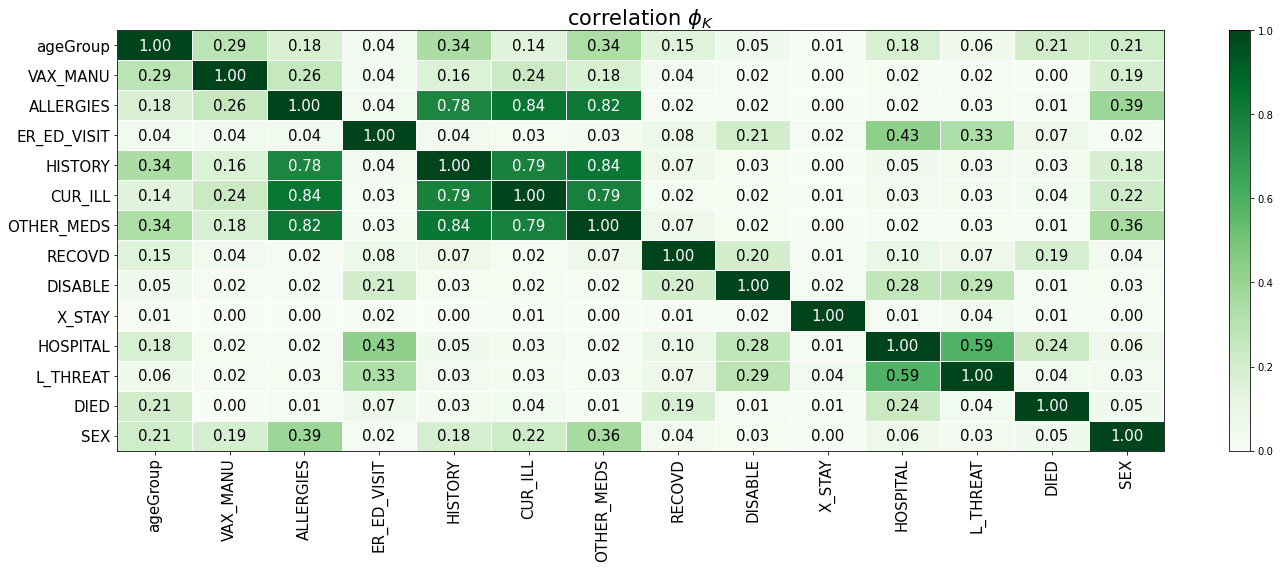

In [20]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

I was interested to see the Correlation signals betweeen:

vaccines-Population status (vaccine brand, ageGroup, gender, medical history, current illnes, current medications, allergy) with:

1.1. recovery outcomes:(yes, no) after Vaccine administration

1.2. serious outcomes after the administration each vaccine: (yes, no)

 (Death, life threatening, disability, emergency visit, prolonged hospitalized days)
 


### Significance of the correlations
When assessing correlations we should not only look at the coefficients but also at their statistical significance. Because in the end, a large correlation may be statistically insignificant, and vice versa.

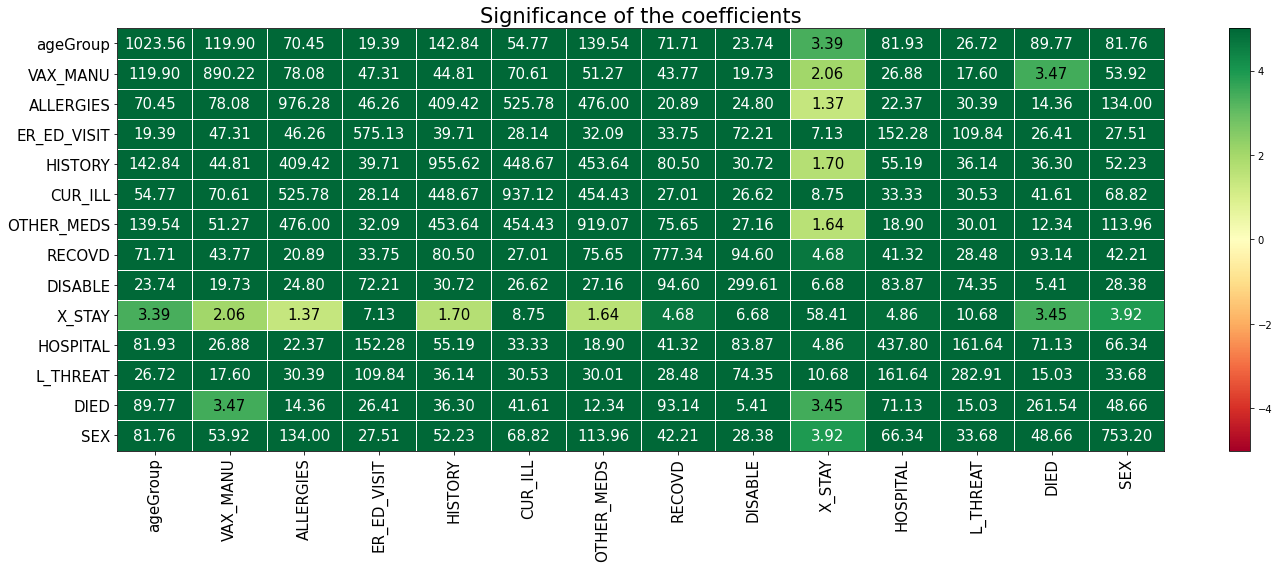

In [21]:
significance_overview = df_covid_corr.significance_matrix()
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 8))
plt.tight_layout()

### Global correlation

The global correlation coefficient is a useful measure expressing the total correlation of one variable to all other variables in the dataset. This gives us an indication of how well one variable can be modeled using the other variables.

Majority of variables have relatively high values of the global correlation metric, with the highest one going to "Allergies, Medictaions, Current Illness, and Medical History". We have seen before that there was positive correlation between population-health status and some other serious-vaccine-outcomes stats, hence the highest score here.


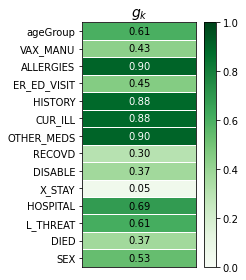

In [22]:
global_correlation, global_labels = df_covid_corr.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.0)
print('Majority of variables have relatively high values of the global correlation metric, with the highest one going to "Allergies, Medictaions, Current Illness, and Medical History". We have seen before that there was positive correlation between population-health status and some other serious-vaccine-outcomes stats, hence the highest score here.')
plt.tight_layout()

__framework__

- identify the variables that are binary, categorical and not ordinal, categorical and ordinal: 
 > - start by identifying the number of unique values
 > - encode the variables based on either categories

In [16]:
df_uniques = df_covid_corr.nunique()

In [17]:
binary_variables = list(df_uniques[df_uniques == 2].index)
binary_variables

['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'RECOVD', 'ER_ED_VISIT']

In [18]:
categorical_variables = list(df_uniques[df_uniques > 2].index)

In [19]:
[[i, list(df_covid[i].unique())] for i in categorical_variables]

[['SEX', ['F', 'M', 'U']],
 ['OTHER_MEDS', ['Y', 'U', 'N']],
 ['CUR_ILL', ['N', 'U', 'Y']],
 ['HISTORY', ['N', 'U', 'Y']],
 ['ALLERGIES', ['N', 'U', 'Y']],
 ['VAX_MANU', ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN']],
 ['ageGroup',
  ['Adults:45-64',
   'Adults:18-44',
   'Adults:65+',
   'Teens:12-17',
   'Children:1-11',
   'Infants:<1']]]

In [20]:
ordinal_variable = ['ageGroup']

In [21]:
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder

In [22]:
lb, oe = LabelBinarizer(), OrdinalEncoder()

In [24]:
lb.classes

AttributeError: 'LabelBinarizer' object has no attribute 'classes'

In [74]:
for column in binary_variables:
    df_covid_corr[column] = lb.fit_transform(df_covid_corr[column]) 

In [75]:
df_covid_corr[ordinal_variable] = oe.fit_transform(df_covid_corr[ordinal_variable])  

In [76]:
categorical_variables = list(set (categorical_variables) - set(ordinal_variable)) 

In [77]:
encoded_df = pd.get_dummies(df_covid_corr, columns= categorical_variables, drop_first=True)

In [78]:
encoded_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DIED,436116.0,0.015143,0.122121,0.0,0.0,0.0,0.0,1.0
L_THREAT,436116.0,0.018419,0.134463,0.0,0.0,0.0,0.0,1.0
HOSPITAL,436116.0,0.057418,0.232640,0.0,0.0,0.0,0.0,1.0
X_STAY,436116.0,0.000454,0.021303,0.0,0.0,0.0,0.0,1.0
DISABLE,436116.0,0.021279,0.144312,0.0,0.0,0.0,0.0,1.0
RECOVD,436116.0,0.487584,0.499846,0.0,0.0,0.0,1.0,1.0
ER_ED_VISIT,436116.0,0.126297,0.332184,0.0,0.0,0.0,0.0,1.0
ageGroup,436116.0,0.988858,1.060050,0.0,0.0,1.0,2.0,5.0
VAX_MANU_MODERNA,436116.0,0.467330,0.498932,0.0,0.0,0.0,1.0,1.0
VAX_MANU_PFIZER\BIONTECH,436116.0,0.457032,0.498151,0.0,0.0,0.0,1.0,1.0


In [79]:
encoded_df.to_csv(working_directory +'/VAERSData/encoded_df.csv', index = False)

In [96]:
y= (encoded_df['RECOVD'] == 1).astype(int)
fields= list(encoded_df.columns.drop('RECOVD'))
correlations = encoded_df[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations.round(2)

DISABLE                    -0.13
DIED                       -0.12
OTHER_MEDS_Y               -0.11
HISTORY_Y                  -0.11
VAX_MANU_PFIZER\BIONTECH   -0.06
HOSPITAL                   -0.06
ER_ED_VISIT                -0.05
L_THREAT                   -0.04
CUR_ILL_Y                  -0.03
ALLERGIES_Y                -0.03
X_STAY                     -0.01
SEX_M                       0.01
ALLERGIES_U                 0.03
CUR_ILL_U                   0.04
ageGroup                    0.05
SEX_U                       0.06
VAX_MANU_MODERNA            0.06
OTHER_MEDS_U                0.10
HISTORY_U                   0.11
dtype: float64

[(-0.5, 0.5), Text(0, 0.5, 'Pearson correlation')]

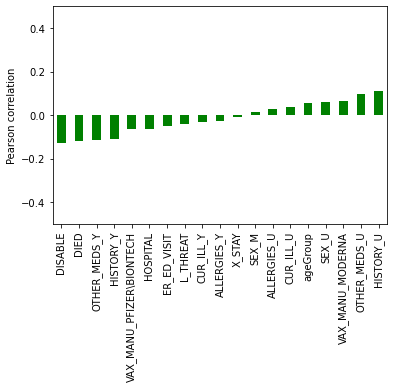

In [97]:
ax = correlations.plot(kind='bar', color='g')
ax.set(ylim=[-0.5, 0.5], ylabel= 'Pearson correlation')

In [92]:
correlations.map(abs).sort_values().iloc[-4:].index

Index(['HISTORY_U', 'OTHER_MEDS_Y', 'DIED', 'DISABLE'], dtype='object')

In [94]:
y= (encoded_df['DIED'] == 1).astype(int)
fields= list(encoded_df.columns.drop('DIED'))
correlations = encoded_df[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations.round(2)

RECOVD                     -0.12
ALLERGIES_Y                -0.02
OTHER_MEDS_Y               -0.01
DISABLE                    -0.01
HISTORY_U                  -0.01
VAX_MANU_MODERNA           -0.00
VAX_MANU_PFIZER\BIONTECH   -0.00
ALLERGIES_U                 0.00
SEX_U                       0.00
CUR_ILL_U                   0.00
X_STAY                      0.01
OTHER_MEDS_U                0.02
L_THREAT                    0.03
ER_ED_VISIT                 0.04
HISTORY_Y                   0.05
CUR_ILL_Y                   0.06
SEX_M                       0.08
ageGroup                    0.08
HOSPITAL                    0.15
dtype: float64

[(-0.5, 0.5), Text(0, 0.5, 'Pearson correlation')]

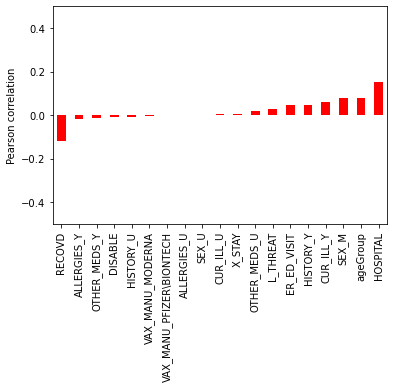

In [95]:
ax = correlations.plot(kind='bar', color='r')
ax.set(ylim=[-0.5, 0.5], ylabel= 'Pearson correlation')

### ----------------------------------------------------------------------------------------------------------------------------